In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU

In [27]:
df = pd.read_csv("/content/Sales_Prediction_Data.csv")
df.shape

(12654, 8)

In [28]:
df.describe()

,year,value
count,12654.000000,1.265400e+04
mean,2019.822112,4.273742e+05
std,5.476494,6.860498e+06
min,2010.000000,1.200000e-06
25%,2016.000000,2.000000e+00
50%,2020.000000,1.300000e+02
75%,2022.000000,5.500000e+03
max,2035.000000,4.400000e+08


In [29]:
df.isnull().sum()

,0
region,0
category,0
parameter,0
mode,0
powertrain,0
year,0
unit,0
value,0


In [30]:
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
1,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


**Feature Engineeing**

In [31]:
ev_sales_df = df[df['parameter'] == 'EV sales']

#EV sales per region and year
region_year_sales = ev_sales_df.groupby(['region', 'year'])['value'].sum().reset_index()
region_year_sales.rename(columns={'value': 'total_sales'}, inplace=True)

#Cumulative EV sales
region_year_sales['cumulative_sales'] = region_year_sales.groupby('region')['total_sales'].cumsum()

#EV sales yearly growth per region
region_year_sales['yoy_growth'] = region_year_sales.groupby('region')['total_sales'].pct_change() * 100

region_year_sales.head(10)

,region,year,total_sales,cumulative_sales,yoy_growth
0,Australia,2011,49.0,49.0,NaN
1,Australia,2012,250.0,299.0,410.204082
2,Australia,2013,290.0,589.0,16.000000
3,Australia,2014,1320.0,1909.0,355.172414
4,Australia,2015,1760.0,3669.0,33.333333
5,Australia,2016,1370.0,5039.0,-22.159091
6,Australia,2017,2300.0,7339.0,67.883212
7,Australia,2018,3600.0,10939.0,56.521739
8,Australia,2019,9200.0,20139.0,155.555556
9,Australia,2020,6900.0,27039.0,-25.000000


**Data Visualization**

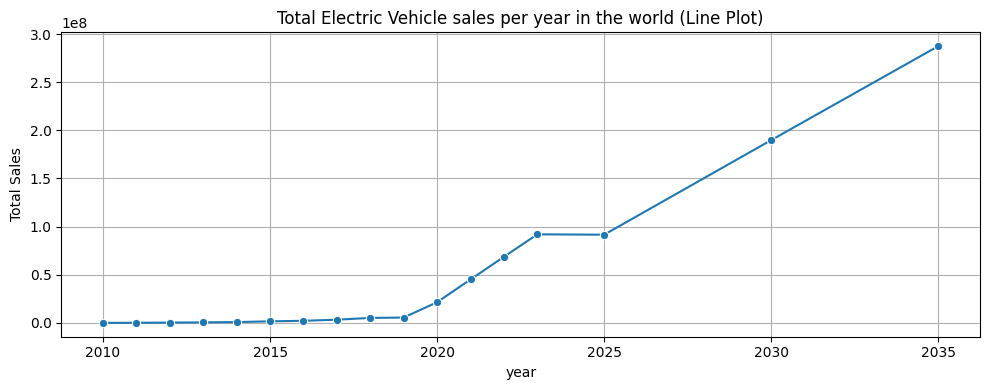

In [32]:
#To calculate EV sales per year in the world by using Line Plot
global_sales = ev_sales_df.groupby('year')['value'].sum().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(data=global_sales, x='year', y='value', marker='o')
plt.title('Total Electric Vehicle sales per year in the world (Line Plot)')
plt.xlabel('year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

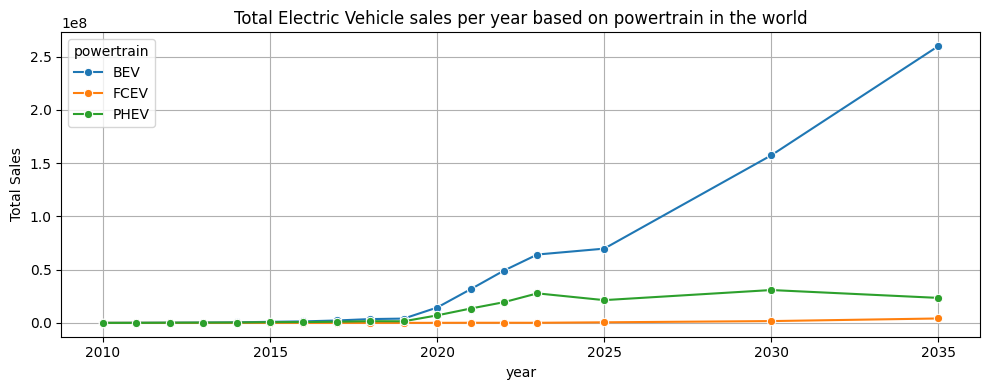

In [33]:
#To calculate powertrain sales per year using line plot
powertrain_sales = ev_sales_df.groupby(['year', 'powertrain'])['value'].sum().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(data=powertrain_sales, x='year', y='value', hue='powertrain', marker='o')
plt.title('Total Electric Vehicle sales per year based on powertrain in the world')
plt.xlabel('year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-34-7be84678fb4e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = Highest_sales, x='value', y='region', palette='magma')


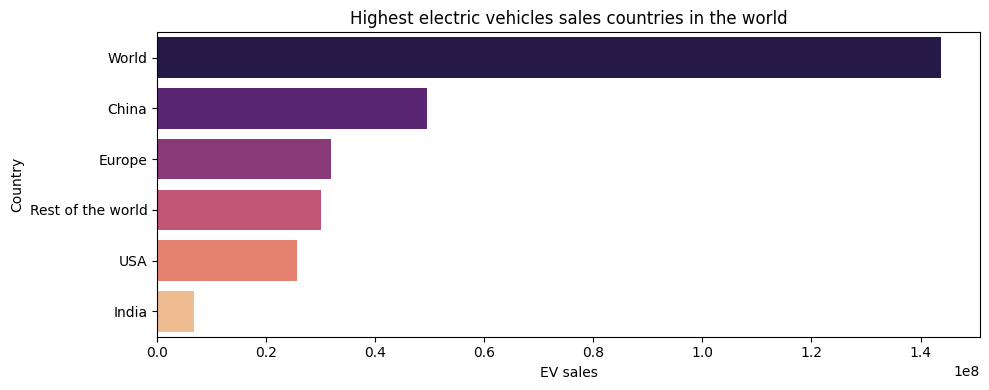

In [34]:
#To calculate most EV sales conutries in the world by using bar chart
sales_year = ev_sales_df['year'].max()
Highest_sales = ev_sales_df[ev_sales_df['year'] == sales_year].groupby('region')['value'].sum().reset_index()
Highest_sales = Highest_sales.sort_values(by='value', ascending=False).head(6)
plt.figure(figsize=(10,4))
sns.barplot(data = Highest_sales, x='value', y='region', palette='magma')
plt.title('Highest electric vehicles sales countries in the world')
plt.xlabel('EV sales')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

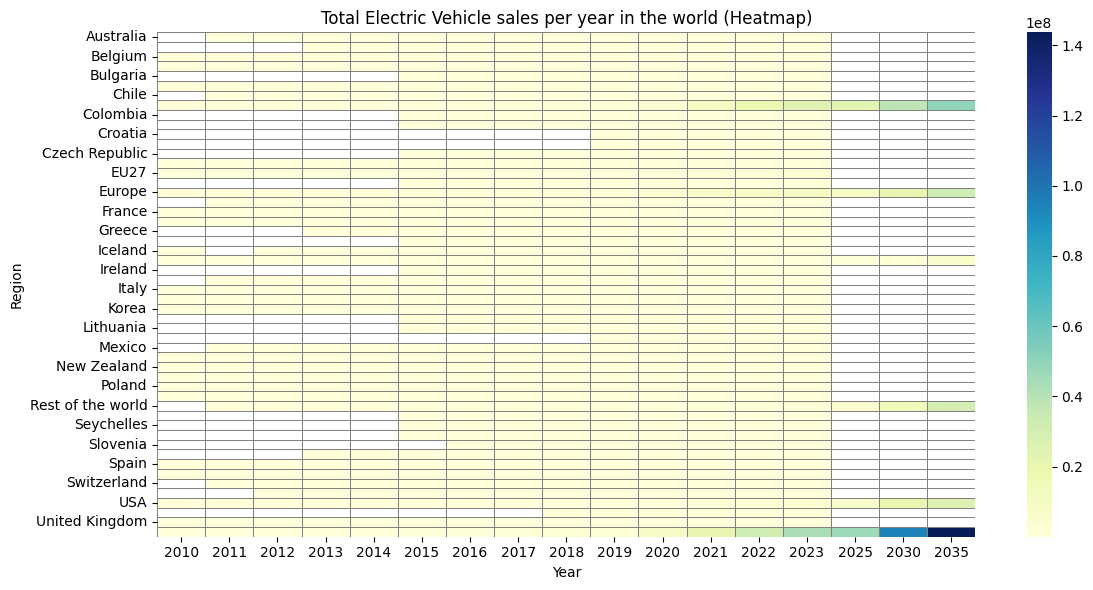

In [35]:
#To calculate EV sales per year in the world by using heat map
Heatmap_data = region_year_sales.pivot(index='region', columns='year', values='total_sales')
plt.figure(figsize=(12,6))
sns.heatmap(Heatmap_data, cmap='YlGnBu', linewidth=0.5, linecolor='gray')
plt.title('Total Electric Vehicle sales per year in the world (Heatmap)')
plt.xlabel('Year')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

**Model Implementation**

In [36]:
#Data pre-processing
New_df = df[df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
New_df.rename(columns={'value': 'total_sales'}, inplace=True)
X = New_df[['year']]
y = New_df[['total_sales']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=537)

#Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Support Vector Regressor": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(max_iter=1000)
}


In [37]:
#Training
result = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    duration = end - start

    result.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "TIME": duration
    })

result_df = pd.DataFrame(result).sort_values(by='R^2', ascending=False).reset_index(drop=True)
result_df

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

,Model,MSE,RMSE,R^2,TIME
0,Linear Regression,7.208176e+15,8.490098e+07,0.516335,0.008572
1,Lasso,7.208176e+15,8.490098e+07,0.516335,0.008375
2,Ridge,7.248117e+15,8.513587e+07,0.513655,0.005760
3,ElasticNet,7.465124e+15,8.640095e+07,0.499094,0.019902
4,AdaBoost,1.199985e+16,1.095438e+08,0.194816,0.161029
5,Decision Tree,1.199989e+16,1.095440e+08,0.194813,0.004999
6,Gradient Boosting,1.200015e+16,1.095452e+08,0.194796,0.197169
7,Random Forest,1.248187e+16,1.117223e+08,0.162473,0.327728
8,KNN,1.661326e+16,1.288924e+08,-0.114742,0.009065
9,Support Vector Regressor,2.915180e+16,1.707390e+08,-0.956072,0.005247


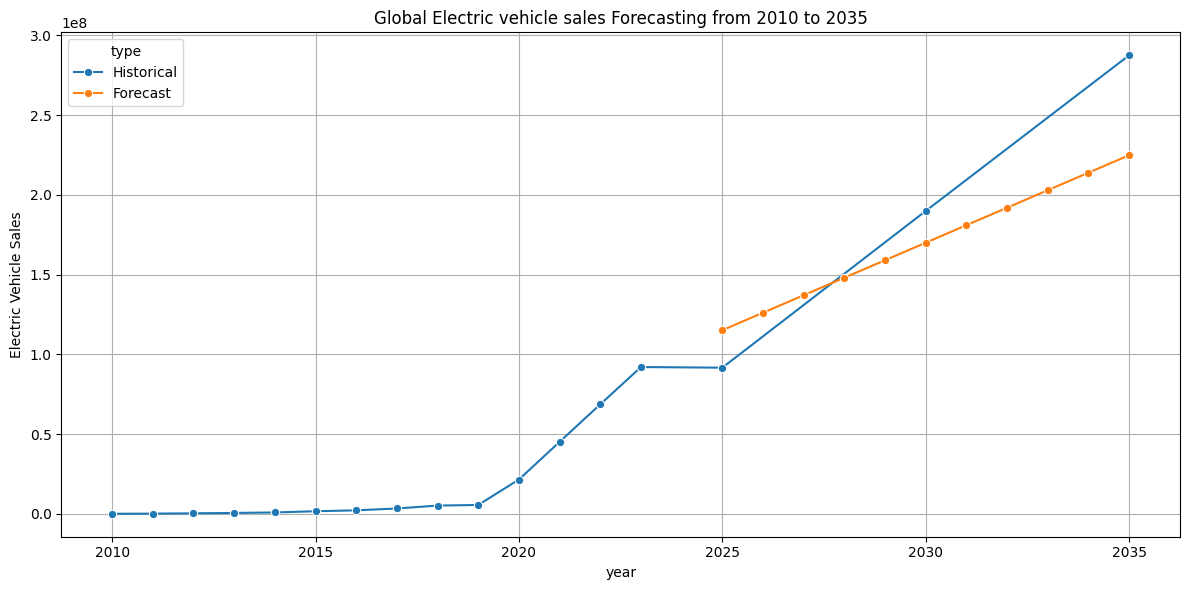

In [38]:
#Forecasting
best_model = LinearRegression()
best_model.fit(X,y)

future_year = pd.DataFrame({'year': list(range(2025, 2036))})
future_pred = best_model.predict(future_year)

historical_df = X.copy()
historical_df['total_sales'] = y
historical_df['type'] = 'Historical'

future_df = future_year.copy()
future_df['total_sales'] = future_pred
future_df['type'] = 'Forecast'

combined_df = pd.concat([historical_df, future_df], axis=0).reset_index(drop=True)
plt.figure(figsize=(12,6))
sns.lineplot(data=combined_df, x='year', y='total_sales', hue='type', marker='o')
plt.title('Global Electric vehicle sales Forecasting from 2010 to 2035')
plt.xlabel('year')
plt.ylabel('Electric Vehicle Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
#Deep learning models
#Data pre-processing
dl_df = df[df['parameter'] == 'EV sales'].groupby('year')['value'].sum().reset_index()
dl_df.rename(columns={'value': 'total_sales'}, inplace=True)
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(dl_df[['total_sales']])
X_dl, y_dl = [], []
window = 3
for i in range(window, len(scaled_sales)):
    X_dl.append(scaled_sales[i-window:i])
    y_dl.append(scaled_sales[i])

X_dl, y_dl = np.array(X_dl), np.array(y_dl)
split = int(0.8 * len(X_dl))
X_train_dl, X_test_dl = X_dl[:split], X_dl[split:]
y_train_dl, y_test_dl = y_dl[:split], y_dl[split:]

In [40]:
#Dense neural network implementation
model_dense = Sequential([
    Flatten(input_shape=(X_train_dl.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model_dense.compile(optimizer='adam', loss='mse')
history_dense = model_dense.fit(X_train_dl, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_dl, y_test_dl))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
#LSTM model implementation
X_train_lstm = X_train_dl.reshape(X_train_dl.shape[0], X_train_dl.shape[1], 1)
X_test_lstm = X_test_dl.reshape(X_test_dl.shape[0], X_test_dl.shape[1], 1)
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train_dl, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_dl, y_test_dl))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
#GRU model implementation
model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train_dl, y_train_dl, epochs=200, verbose=0, validation_data=(X_test_dl, y_test_dl))

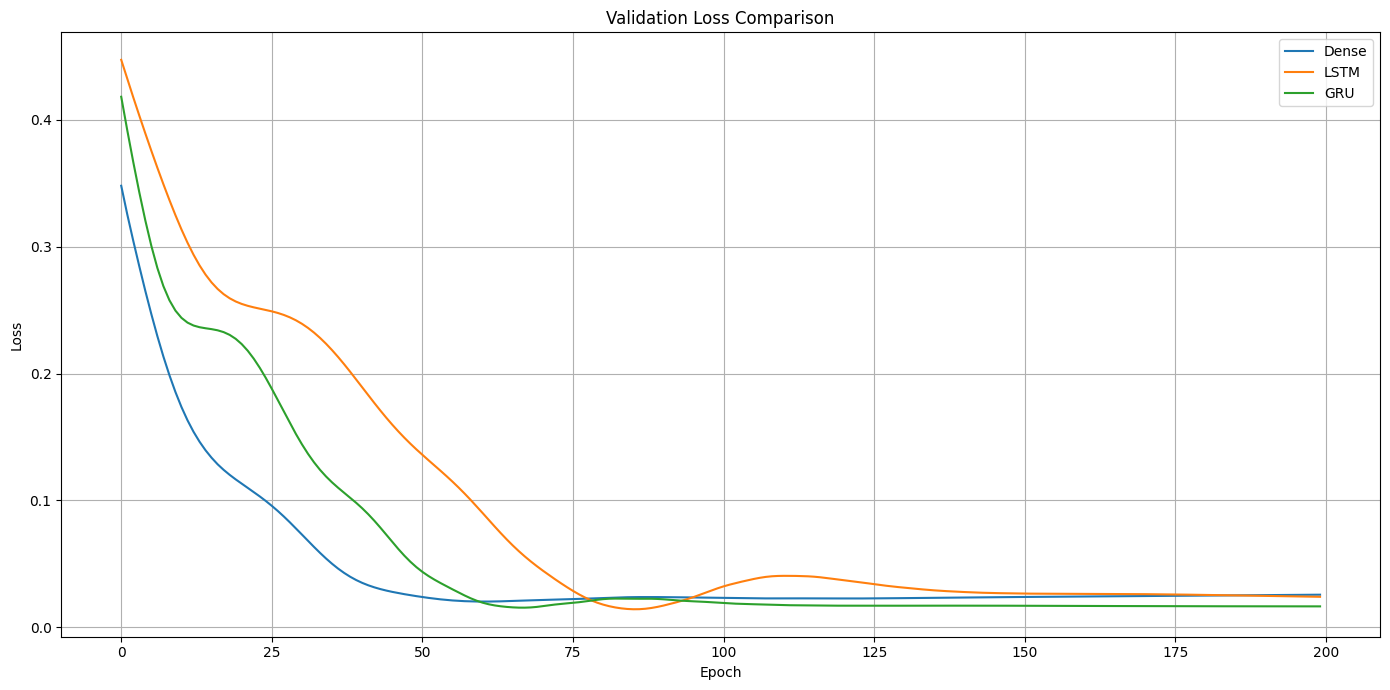

In [43]:
#Validation Loss Comparison
plt.figure(figsize=(14,7))
plt.plot(history_dense.history['val_loss'], label='Dense')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Comparison Between Actual and Predicted Values**

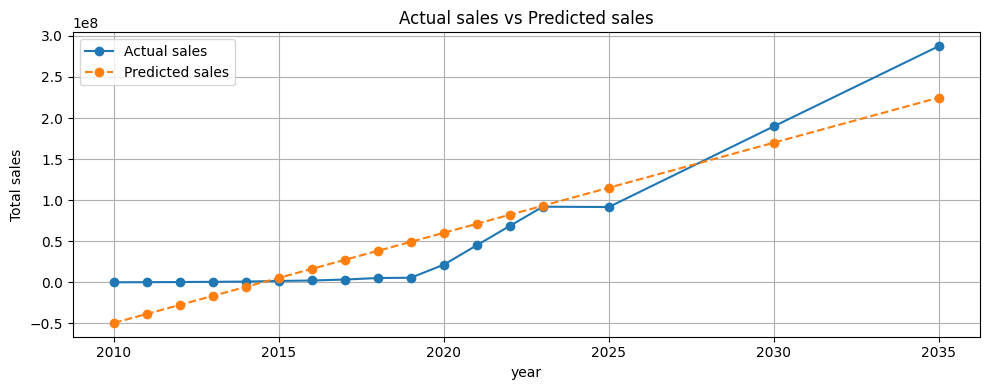

In [44]:
#Linear Regression
lr_model =  LinearRegression()
lr_model.fit(X,y)
y_lr_pred = lr_model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(X['year'], y, label='Actual sales', marker='o')
plt.plot(X['year'], y_lr_pred, label='Predicted sales', marker='o', linestyle='--')
plt.title("Actual sales vs Predicted sales")
plt.xlabel('year')
plt.ylabel('Total sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


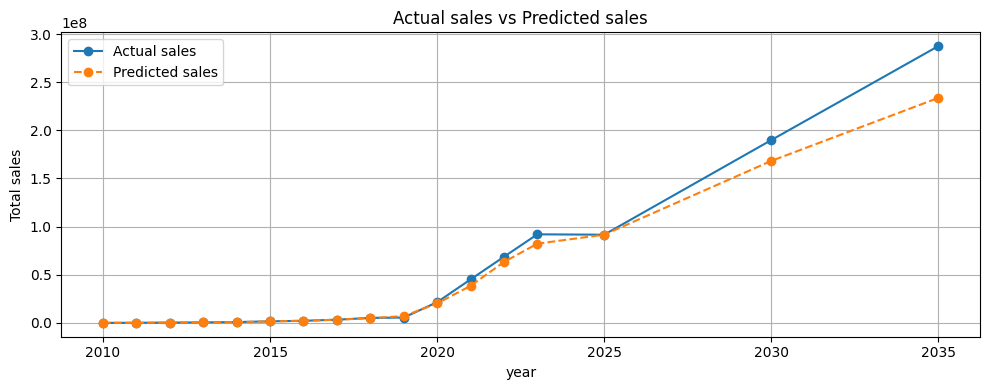

In [45]:
#Random Forest
rf_model =   RandomForestRegressor()
rf_model.fit(X,y)
y_rf_pred = rf_model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(X['year'], y, label='Actual sales', marker='o')
plt.plot(X['year'], y_rf_pred, label='Predicted sales', marker='o', linestyle='--')
plt.title("Actual sales vs Predicted sales")
plt.xlabel('year')
plt.ylabel('Total sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

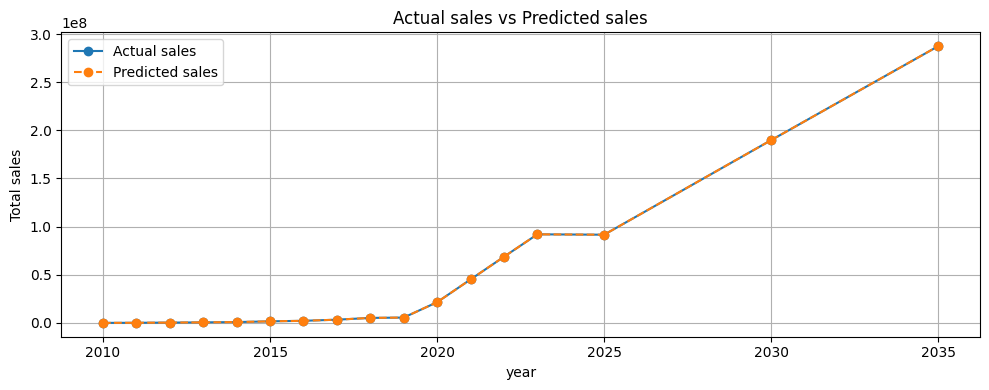

In [46]:
#Decision Tree
dt_model =   DecisionTreeRegressor()
dt_model.fit(X,y)
y_dt_pred = dt_model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(X['year'], y, label='Actual sales', marker='o')
plt.plot(X['year'], y_dt_pred, label='Predicted sales', marker='o', linestyle='--')
plt.title("Actual sales vs Predicted sales")
plt.xlabel('year')
plt.ylabel('Total sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


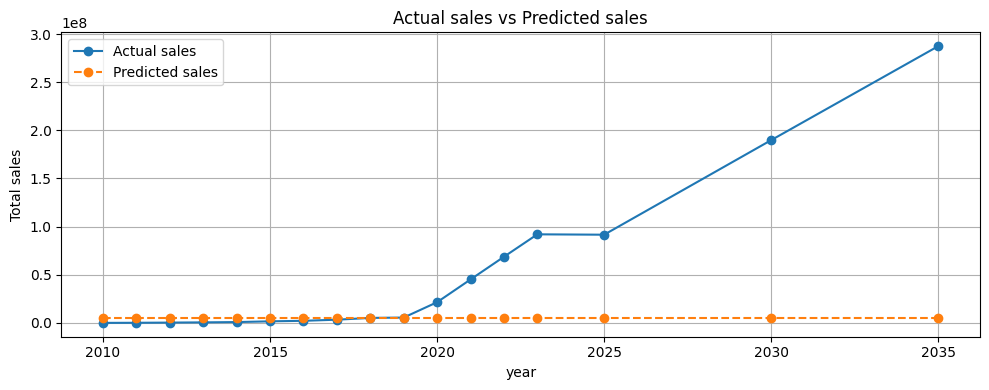

In [47]:
#Support Vector Regressor
svr_model =   SVR()
svr_model.fit(X,y)
y_svr_pred = svr_model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(X['year'], y, label='Actual sales', marker='o')
plt.plot(X['year'], y_svr_pred, label='Predicted sales', marker='o', linestyle='--')
plt.title("Actual sales vs Predicted sales")
plt.xlabel('year')
plt.ylabel('Total sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

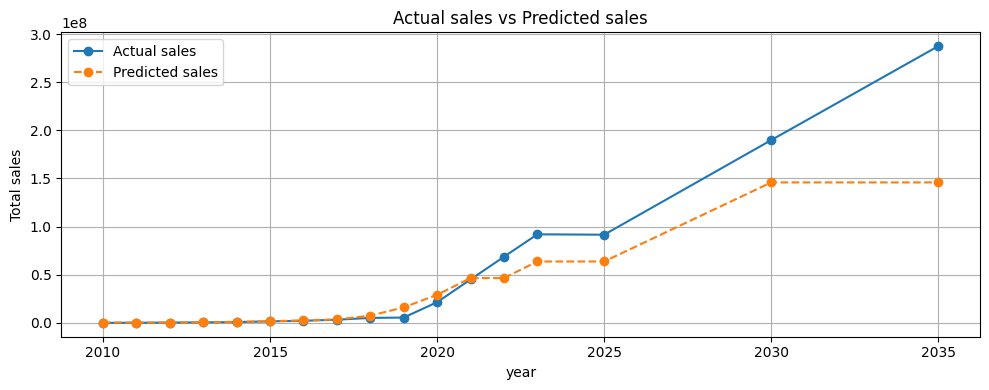

In [48]:
#KNN
knn_model =  KNeighborsRegressor()
knn_model.fit(X,y)
y_knn_pred = knn_model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(X['year'], y, label='Actual sales', marker='o')
plt.plot(X['year'], y_knn_pred, label='Predicted sales', marker='o', linestyle='--')
plt.title("Actual sales vs Predicted sales")
plt.xlabel('year')
plt.ylabel('Total sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()